In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np

import sys
import os

sys.path.append(os.environ['REPO_DIR'] + '/utilities')
from utilities2015 import *
from registration_utilities import *
from metadata import *
from data_manager import *

import matplotlib.pyplot as plt
%matplotlib inline

from joblib import Parallel, delayed
import time

Setting environment for Gordon


In [2]:
stack_fixed = 'MD590'

In [36]:
train_sample_scheme = 1
global_transform_scheme = 1

local_transform_scheme = 2
# 1: no regularization, structures weight the same
# 2: with regularization, structures weight the same
# 3: no regularization, with surround
# 4: with regularization, with surround
# 5: no regularization, structure weight inversely prop to size
# 6: with regularization, structure weight inversely prop to size

if local_transform_scheme == 1:
    reg_weights = np.array([0.,0.,0.])
elif local_transform_scheme == 2:
    reg_weights = np.array([1e-6, 1e-6, 1e-6])
elif local_transform_scheme == 3:
    reg_weights = np.array([0.,0.,0.])
elif local_transform_scheme == 4:
    reg_weights = np.array([1e-4, 1e-4, 1e-4])
    
stack_moving = 'atlas_on_MD589'

In [6]:
paired_structures = ['5N', '6N', '7N', '7n', 'Amb', 'LC', 'LRt', 'Pn', 'Tz', 'VLL', 'RMC', 'SNC', 'SNR', '3N', '4N',
                    'Sp5I', 'Sp5O', 'Sp5C', 'PBG', '10N', 'VCA', 'VCP', 'DC']
singular_structures = ['AP', '12N', 'RtTg', 'SC', 'IC']
structures = paired_structures + singular_structures

In [7]:
label_to_name_fixed = {i+1: name for i, name in enumerate(sorted(structures))}
name_to_label_fixed = {n:l for l, n in label_to_name_fixed.iteritems()}

In [8]:
# name_to_label_moving = DataManager.load_annotation_volume_nameToLabel(stack='MD589', downscale=32)
# label_to_name_moving = {l:n for n, l in name_to_label_moving.iteritems()}

In [9]:
structures_sided = sum([[n] if n in singular_structures 
                        else [convert_to_left_name(n), convert_to_right_name(n)] 
                        for n in structures], [])

In [10]:
if local_transform_scheme == 1 or local_transform_scheme == 2:
    
    label_to_name_moving = {i+1: name for i, name in enumerate(structures_sided)}
    name_to_label_moving = {n:l for l, n in label_to_name_moving.iteritems()}

elif local_transform_scheme == 3 or local_transform_scheme == 4:

    structures_sided_plus_surround = sum([[s, s+'_surround'] for s in structures_sided], [])

    label_to_name_moving = {i+1: name for i, name in enumerate(structures_sided_plus_surround)}
    name_to_label_moving = {n:l for l, n in label_to_name_moving.iteritems()}

In [11]:
# Load fixed volumes

volume_fixed = {name_to_label_fixed[name]: DataManager.load_score_volume(stack=stack_fixed, label=name, downscale=32, train_sample_scheme=train_sample_scheme)
               for name in structures}

print volume_fixed.values()[0].shape
print volume_fixed.values()[0].dtype

vol_fixed_xmin, vol_fixed_ymin, vol_fixed_zmin = (0,0,0)
vol_fixed_ymax, vol_fixed_xmax, vol_fixed_zmax = np.array(volume_fixed.values()[0].shape) - 1
vol_fixed_xdim = vol_fixed_xmax + 1 - vol_fixed_xmin
vol_fixed_ydim = vol_fixed_ymax + 1 - vol_fixed_ymin
vol_fixed_zdim = vol_fixed_zmax + 1 - vol_fixed_zmin

(408, 548, 358)
float16


In [10]:
# volume_moving = bp.unpack_ndarray_file(DataManager.get_transformed_volume_filepath(stack_m='MD589', type_m='annotation',
#                                                            stack_f=stack_fixed, type_f='score',
#                                                            downscale=32,
#                                                            train_sample_scheme_f=1))

# print volume_moving.shape

# vol_moving_xmin, vol_moving_ymin, vol_moving_zmin = (0,0,0)
# vol_moving_ymax, vol_moving_xmax, vol_moving_zmax = np.array(volume_moving.shape) - 1

In [11]:
# volume_moving = {name_to_label_moving[name_s]: DataManager.load_transformed_volume(stack_m='atlas_on_MD589',
#                                                                                    type_m='score',
#                                                                                    stack_f=stack_fixed,
#                                                                                    type_f='score',
#                                                                                    downscale=32,
#                                                                                    train_sample_scheme_f=train_sample_scheme,
#                                                                                    label=name_s)
#                  for name_s in structures_sided}

In [12]:
# volume_moving = {name_to_label_moving[name_s]: DataManager.load_transformed_volume(stack_m='atlas_on_MD589',
#                                                                                    type_m='score',
#                                                                                    stack_f=stack_fixed,
#                                                                                    type_f='score',
#                                                                                    downscale=32,
#                                                                                    train_sample_scheme_f=train_sample_scheme,
#                                                                                    label=name_s)
#                  for name_s in structures_sided_plus_surround}

In [12]:
# Load moving volumes

if local_transform_scheme == 3 or local_transform_scheme == 4:

    volume_moving = {name_to_label_moving[name_s]: DataManager.load_transformed_volume(stack_m='atlas_on_MD589',
                                                                                       type_m='score',
                                                                                       stack_f=stack_fixed,
                                                                                       type_f='score',
                                                                                       downscale=32,
                                                                                       train_sample_scheme_f=train_sample_scheme,
                                                                                       label=name_s)
                     for name_s in structures_sided_plus_surround}

else:

    volume_moving = {name_to_label_moving[name_s]: DataManager.load_transformed_volume(stack_m='atlas_on_MD589',
                                                                                       type_m='score',
                                                                                       stack_f=stack_fixed,
                                                                                       type_f='score',
                                                                                       downscale=32,
                                                                                       train_sample_scheme_f=train_sample_scheme,
                                                                                       label=name_s)
                     for name_s in structures_sided}    
    
print volume_moving.values()[0].shape
print volume_moving.values()[0].dtype

vol_moving_xmin, vol_moving_ymin, vol_moving_zmin = (0,0,0)
vol_moving_ymax, vol_moving_xmax, vol_moving_zmax = np.array(volume_moving.values()[0].shape) - 1

(408, 548, 358)
float16


In [14]:
# volume_moving_structure_sizes = {l: np.count_nonzero(vol > 0) for l, vol in volume_moving.iteritems()}

# for lm, s in volume_moving_structure_sizes.iteritems():
#     print label_to_name_moving[lm], s, 'voxels'

In [13]:
def convert_to_original_name(name):
    return name.split('_')[0]

labelIndexMap_m2f = {}
for label_m, name_m in label_to_name_moving.iteritems():
    labelIndexMap_m2f[label_m] = name_to_label_fixed[convert_to_original_name(name_m)]
    
label_weights_m = {}
for label_m, name_m in label_to_name_moving.iteritems():
    if 'surround' in name_m:
        if local_transform_scheme == 3 or local_transform_scheme == 4:
            label_weights_m[label_m] = -1
        else:
            label_weights_m[label_m] = 0
    else:
        label_weights_m[label_m] = 1

5N_L
set([5])


load gradient 5: 0.644114 seconds
overall: 0.644280 seconds
grid search: 0.547022 seconds
-inf 0.022171
grid search: 0.484990 seconds
grid search: 0.360979 seconds
grid search: 0.365116 seconds
grid search: 0.360590 seconds
0.022171 0.022582
grid search: 0.260342 seconds
grid search: 0.262704 seconds
0.022582 0.022836
grid search: 0.260647 seconds
grid search: 0.247639 seconds
0.022836 0.022886
grid search: 0.269754 seconds
0.022886 0.022894
iteration 0
score: 0.022894
iteration 1
score: 0.022210
iteration 2
score: 0.016712
iteration 3
score: 0.020997
iteration 4
score: 0.020645
iteration 5
score: 0.021799
iteration 6
score: 0.022106
iteration 7
score: 0.022521
iteration 8
score: 0.022637
iteration 9
score: 0.022770
iteration 10
score: 0.022836
iteration 11
score: 0.022895
iteration 12


params_best_upToNow [ 2.27980306 -0.62013901 -1.4913029   0.06158161]


score: 0.022870
iteration 13
score: 0.022908
iteration 14
score: 0.022903
iteration 15
score: 0.022913
iteration 16
score: 0.022901
iteration 17
score: 0.022919
iteration 18
score: 0.022903
iteration 19
score: 0.022930
iteration 20
score: 0.022917
iteration 21
score: 0.022930
iteration 22
score: 0.022938
iteration 23
score: 0.022941
iteration 24
score: 0.022928
iteration 25
score: 0.022965
iteration 26
score: 0.022943
iteration 27
score: 0.022946
iteration 28
score: 0.022949
iteration 29
score: 0.022947
iteration 30
score: 0.022966
iteration 31
score: 0.022963
iteration 32
score: 0.022963
iteration 33
score: 0.022964
iteration 34
score: 0.022988
iteration 35
score: 0.022997
iteration 36
score: 0.023006
iteration 37
score: 0.023017
iteration 38
score: 0.023014
iteration 39
score: 0.023029
iteration 40
score: 0.023026
iteration 41
score: 0.023033
iteration 42
score: 0.023015
iteration 43
score: 0.023013
iteration 44
score: 0.023017
iteration 45
score: 0.023011
iteration 46
score: 0.02300

[[ 0.99817679 -0.04674722 -0.03818117  1.70641947]
 [ 0.04438211  0.99717467 -0.06060444 -0.52031949]
 [ 0.04090639  0.05879939  0.99743135 -1.43360475]]
0.0230331979473 0.0230138036165


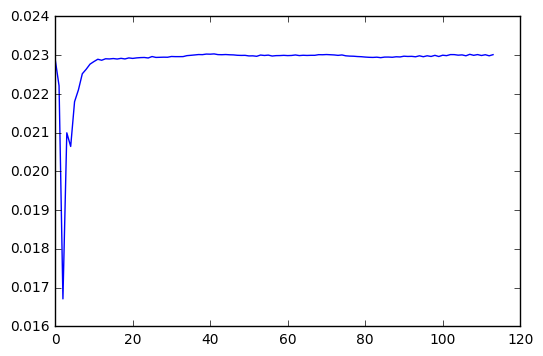

In [43]:
# for name_s in structures_sided:
for name_s in ['5N_L']:
# for name_s in ['IC']:
    
    print name_s

#     try:
        
    if local_transform_scheme == 1 or local_transform_scheme == 2:
    
        aligner = Aligner4(volume_fixed, {name_to_label_moving[name_s]: 
                                          volume_moving[name_to_label_moving[name_s]]}, \
                           labelIndexMap_m2f={name_to_label_moving[name_s]:
                                              name_to_label_fixed[convert_name_to_unsided(name_s)]})

    elif local_transform_scheme == 3 or local_transform_scheme == 4:
                
        aligner = Aligner4(volume_fixed, {name_to_label_moving[name_s]: volume_moving[name_to_label_moving[name_s]],
                                         name_to_label_moving[name_s+'_surround']: volume_moving[name_to_label_moving[name_s+'_surround']]}, \
                        labelIndexMap_m2f={name_to_label_moving[name_s]: name_to_label_fixed[convert_name_to_unsided(name_s)],
                                          name_to_label_moving[name_s+'_surround']: name_to_label_fixed[convert_to_original_name(name_s+'_surround')]})

    # aligner.set_centroid(centroid_m='volume_centroid', centroid_f='volume_centroid')
    aligner.set_centroid(centroid_m='structure_centroid', centroid_f='centroid_m', 
                         indices_m=[name_to_label_moving[name_s]])

    gradient_filepath_map_f = {ind_f: VOLUME_ROOTDIR + '/%(stack)s/score_volume_gradients/%(stack)s_down32_scoreVolume_%(label)s_trainSampleScheme_%(scheme)d_%%(suffix)s.bp' % \
                           {'stack': stack_fixed, 'label': label_to_name_fixed[ind_f], 'scheme':train_sample_scheme}
                           for ind_m, ind_f in labelIndexMap_m2f.iteritems()}

    aligner.load_gradient(gradient_filepath_map_f=gradient_filepath_map_f, indices_f=None)

    t = time.time()
    
    # SC + SC_surround
    # grid_search_sample_number = 100, 6.2s (first iter) x 10 iters (exp. diminishing) ~ 20s
    # grid_search_sample_number = 1000, 40s (first iter) x 10 iters ~ 143s
    # grid_search_sample_number = 10000, 380s (first iter) x 10 iters ~ 1315s
    
    # IC + IC_surround
    # grid_search_sample_number = 100, 4s (first iter)
    # grid_search_sample_number = 1000, 27s (first iter)
    # grid_search_sample_number = 10000, 215s (first iter)
    T, scores = aligner.optimize(type='rigid', max_iter_num=1000, history_len=50, terminate_thresh=1e-5,
                                 indices_m=None,
                                grid_search_iteration_number=10,
                                 grid_search_sample_number=1000,
                                 grad_computation_sample_number=1e5,
                                 lr1=10, lr2=0.1,
                                label_weights=label_weights_m,
                                std_tx=50, std_ty=50, std_tz=100, std_theta_xy=np.deg2rad(10),
                                reg_weights=reg_weights,
                                epsilon=1e-8)

    sys.stderr.write('%.2f seconds\n' % (time.time() - t))

    print T.reshape((3,4))
    plt.plot(scores);
    print max(scores), scores[-1]

    ########################################################

#     params_fp = DataManager.get_local_alignment_parameters_filepath(stack_moving=stack_moving,
#                                                                 moving_volume_type='score',
#                                                                 stack_fixed=stack_fixed,
#                                                                 fixed_volume_type='score',
#                                                                 train_sample_scheme=train_sample_scheme,
#                                                                 global_transform_scheme=global_transform_scheme,
#                                                                 local_transform_scheme=local_transform_scheme,
#                                                                label=name_s)

#     DataManager.save_alignment_parameters(params_fp, 
#                                           T, aligner.centroid_m, aligner.centroid_f, 
#                                           aligner.xdim_m, aligner.ydim_m, aligner.zdim_m, 
#                                           aligner.xdim_f, aligner.ydim_f, aligner.zdim_f)


#     score_plot_fp = DataManager.get_local_alignment_score_plot_filepath(stack_moving=stack_moving,
#                                                                     moving_volume_type='score',
#                                                                     stack_fixed=stack_fixed,
#                                                                     fixed_volume_type='score',
#                                                                     train_sample_scheme=train_sample_scheme,
#                                                                     global_transform_scheme=global_transform_scheme,
#                                                                     local_transform_scheme=local_transform_scheme,
#                                                                    label=name_s)
#     fig = plt.figure();
#     plt.plot(scores);
#     plt.savefig(score_plot_fp, bbox_inches='tight')
#     plt.close(fig)
        
#     except Exception as e:
#         sys.stderr.write(e.message + '\n')
        

In [20]:
aligner.compute_score(T)

0.035221681946676804

In [15]:
from registration_utilities import transform_volume, transform_points, find_contour_points

In [16]:
volumes_annotation = {'MD594': bp.unpack_ndarray_file(DataManager.get_transformed_volume_filepath(stack_m='MD594', type_m='annotation',
                                                stack_f=stack_fixed, type_f='score',
                                                downscale=32, train_sample_scheme_f=1)),
                      
                      'MD589': bp.unpack_ndarray_file(DataManager.get_transformed_volume_filepath(stack_m='MD589', type_m='annotation',
                                                stack_f=stack_fixed, type_f='score',
                                                downscale=32, train_sample_scheme_f=1))}

In [17]:
name_to_label_annotation = DataManager.load_annotation_volume_nameToLabel('MD589', downscale=32)
label_to_name_annotation = {l: n for n, l in name_to_label_annotation.iteritems()}

In [18]:
stack_colors = {'MD589': (255,0,0), 'MD594': (0,255,0)}

In [19]:
structure_colors = {s: np.random.randint(0,255,3) for s in structures}

In [20]:
first_sec, last_sec = metadata_cache['section_limits'][stack_fixed]

In [21]:
xmin_vol_f, xmax_vol_f, ymin_vol_f, ymax_vol_f, zmin_vol_f, zmax_vol_f = np.loadtxt('/home/yuncong/csd395/CSHL_volumes2/%(stack_fixed)s/score_volumes/%(stack_fixed)s_down32_scoreVolume_7N_bbox.txt' %\
          dict(stack_fixed=stack_fixed)).astype(np.int)
print xmin_vol_f, xmax_vol_f, ymin_vol_f, ymax_vol_f, zmin_vol_f, zmax_vol_f

0 547 0 407 110 467


In [22]:
downsample_factor = 32
xy_pixel_distance_downsampled = xy_pixel_distance_lossless * downsample_factor
voxel_z_size = section_thickness / xy_pixel_distance_downsampled

In [23]:
viz_dir = create_if_not_exists(DataManager.get_local_alignment_viz_dir(stack_moving=stack_moving,
                                                        stack_fixed=stack_fixed,
                                                        moving_volume_type='score',
                                                        fixed_volume_type='score',
                                                        train_sample_scheme=train_sample_scheme,
                                                        global_transform_scheme=global_transform_scheme,
                                                        local_transform_scheme=local_transform_scheme))

In [33]:
# tx_params, centroid_m, centroid_f, xdim_m, ydim_m, zdim_m, xdim_f, ydim_f, zdim_f = \
#     DataManager.load_local_alignment_parameters(stack_moving=stack_moving,
#                                                 moving_volume_type='score',
#                                                 stack_fixed=stack_fixed,
#                                                 fixed_volume_type='score',
#                                                 train_sample_scheme=train_sample_scheme,
#                                                 global_transform_scheme=global_transform_scheme,
#                                                 local_transform_scheme=local_transform_scheme,
#                                                label='5N_R')

# annotation_volumes_volume_m_aligned_to_f = {}
# for stack, volume_annotation in volumes_annotation.iteritems():
#     annotation_volumes_volume_m_aligned_to_f[stack] = transform_volume(\
#                                            vol=volume_annotation==name_to_label_annotation['5N_R'], 
#                                                                        global_params=tx_params, 
#                                                                        centroid_m=centroid_m, 
#                                                                        centroid_f=centroid_f,
#                                                                       xdim_f=xdim_f,
#                                                                       ydim_f=ydim_f,
#                                                                       zdim_f=zdim_f).astype(np.uint8)

In [34]:
# bar = show_progress_bar(first_sec, last_sec)

# for sec in range(first_sec, last_sec+1):

#     if metadata_cache['sections_to_filenames'][stack_fixed][sec] in ['Placeholder', 'Rescan', 'Nonexisting']:
#         continue

#     bar.value = sec

#     img_fn = DataManager.get_image_filepath(stack=stack_fixed, section=sec, resol='thumbnail', version='cropped_tif')
#     img = imread(img_fn)

# #         img_fn = DataManager.get_scoremap_viz_filepath(stack=stack_fixed, section=sec, label='7N', train_sample_scheme=train_sample_scheme)
# #         img = imread(img_fn)[::4, ::4]

#     viz = img.copy()

#     z = voxel_z_size * (sec - 1) - zmin_vol_f

#     # Find fixed volume annotation contours
# #     contours_f_on_volume = find_contour_points(volume_fixed[..., int(z)])
# #     contours_f_on_cropped = {i: [cnt + (xmin_vol_f, ymin_vol_f) for cnt in cnts] for i, cnts in contours_f_on_volume.iteritems()}

#     # Find moving volume annotation contours

#     for stack, volume_m_aligned_to_f in annotation_volumes_volume_m_aligned_to_f.iteritems():

#         contours_m_alignedTo_f_on_volume = find_contour_points(volume_m_aligned_to_f[..., int(z)])
#         contours_m_alignedTo_f_on_cropped = {i: [cnt + (xmin_vol_f, ymin_vol_f) for cnt in cnts] 
#                                              for i, cnts in contours_m_alignedTo_f_on_volume.iteritems()}

#     #     # Draw fixed volume annotation contours
#     #     for ind_f, cnts_f in contours_f_on_cropped.iteritems():
#     #         for cnt_f in cnts_f:
#     #             cv2.polylines(viz, [cnt_f.astype(np.int)], True, (0,255,0), 2)

#         # Draw moving volume annotation contours
#         for ind_m, cnts_m in contours_m_alignedTo_f_on_cropped.iteritems():
#             for cnt_m in cnts_m:
#                 cv2.polylines(viz, [cnt_m.astype(np.int)], True, stack_colors[stack], 2)

#     viz_fn = os.path.join(viz_dir, '%(stack_moving)s_over_%(stack_fixed)s_%(sec)04d.jpg' % \
#           {'stack_moving': stack_moving, 'stack_fixed': stack_fixed, 'sec': sec})
#     imsave(viz_fn, viz)

In [27]:
annotation_structure_sizes = {s: len(parallel_where_binary(volume_annotation == name_to_label_annotation[s])) 
                              for s in structures_sided}
annotation_structure_sizes_precent = {s: float(size)/sum(annotation_structure_sizes.values()) 
                                      for s, size in annotation_structure_sizes.iteritems()}

In [175]:
annotation_structure_radius = {}
# annotation_structure_axes = {}
annotation_structure_covars = {}
for s in structures_sided:
    nzs = parallel_where_binary(volume_annotation == name_to_label_annotation[s])
    nzsc = nzs - nzs.mean(axis=0)
    C = np.dot(nzsc.T, nzsc)/float(len(nzsc))
    S, V = np.linalg.eigh(C)
#     annotation_structure_axes[s] = V
    annotation_structure_radius[s] = np.sqrt(S)
    annotation_structure_covars[s] = C
#     alpha = 1.
#     scaled_C = np.dot(np.dot(V.T, alpha*S), V)
#     annotation_structure_covars[s] = scaled_C

In [210]:
# Read Transform of each structure, do polyrigid transform

volume_m_aligned_to_f_allAnnotatedBrains = {}

stack = 'MD589'
volume_annotation = volumes_annotation[stack]

# for stack, volume_annotation in volumes_annotation.iteritems():

rigid_parameters_list = []
anchor_points = []
# sigmas = [1. for _ in structures_sided]

alpha = 1.
sigmas = [alpha * annotation_structure_covars[s] for s in structures_sided]

# weights = [1. for s in structures_sided]
weights = [annotation_structure_sizes_precent[s] for s in structures_sided]

for name_s in structures_sided:
# for name_s in ['VLL_L']:

    try:
        tx_params, centroid_m, centroid_f, xdim_m, ydim_m, zdim_m, xdim_f, ydim_f, zdim_f = \
        DataManager.load_local_alignment_parameters(stack_moving=stack_moving,
                                                    moving_volume_type='score',
                                                    stack_fixed=stack_fixed,
                                                    fixed_volume_type='score',
                                                    train_sample_scheme=train_sample_scheme,
                                                    global_transform_scheme=global_transform_scheme,
                                                    local_transform_scheme=local_transform_scheme,
                                                   label=name_s,
                                                   trial_idx=1)

        rigid_parameters_list.append((tx_params, centroid_m, centroid_f, xdim_m, ydim_m, zdim_m, xdim_f, ydim_f, zdim_f))
        anchor_points.append(centroid_m)
    except:
        sys.stderr.write('Cannot load parameters for %s.\n' % name_s)

In [211]:
volume_m_aligned_to_f_allAnnotatedBrains[stack] = transform_volume_polyrigid(volume_annotation, 
                                                                             rigid_parameters_list, 
                                                                             anchor_points, sigmas, 
                                                                             weights)

In [212]:
viz_dir = create_if_not_exists(DataManager.get_local_alignment_viz_dir(stack_moving=stack_moving,
                                                        stack_fixed=stack_fixed,
                                                        moving_volume_type='score',
                                                        fixed_volume_type='score',
                                                        train_sample_scheme=train_sample_scheme,
                                                        global_transform_scheme=global_transform_scheme,
                                                        local_transform_scheme=5))

In [213]:
bar = show_progress_bar(first_sec, last_sec)

for sec in range(first_sec, last_sec+1):
# for sec in range(140, 160):
    
    if metadata_cache['sections_to_filenames'][stack_fixed][sec] in ['Placeholder', 'Rescan', 'Nonexisting']:
            continue

    bar.value = sec

    img_fn = DataManager.get_image_filepath(stack=stack_fixed, section=sec, resol='thumbnail', version='cropped_tif')
    img = imread(img_fn)

#         img_fn = DataManager.get_scoremap_viz_filepath(stack=stack_fixed, section=sec, label='7N', train_sample_scheme=train_sample_scheme)
#         img = imread(img_fn)[::4, ::4]

    viz = img.copy()

    z = voxel_z_size * (sec - 1) - zmin_vol_f
    
    ##############################################
    
#     for stack, volume_m_aligned_to_f in volume_m_aligned_to_f_allAnnotatedBrains.iteritems():

    stack = 'MD589'
    volume_m_aligned_to_f = volume_m_aligned_to_f_allAnnotatedBrains[stack]
            
    contours_m_alignedTo_f_on_volume = find_contour_points(volume_m_aligned_to_f[..., int(z)])
    contours_m_alignedTo_f_on_cropped = {i: [cnt + (xmin_vol_f, ymin_vol_f) for cnt in cnts] 
                                         for i, cnts in contours_m_alignedTo_f_on_volume.iteritems()}

#     # Draw fixed volume annotation contours
#     for ind_f, cnts_f in contours_f_on_cropped.iteritems():
#         for cnt_f in cnts_f:
#             cv2.polylines(viz, [cnt_f.astype(np.int)], True, (0,255,0), 2)

    # Draw moving volume annotation contours
    for ind_m, cnts_m in contours_m_alignedTo_f_on_cropped.iteritems():
        for cnt_m in cnts_m:
#             cv2.polylines(viz, [cnt_m.astype(np.int)], True, stack_colors[stack], 2)
            cv2.polylines(viz, [cnt_m.astype(np.int)], True, structure_colors[convert_name_to_unsided(label_to_name_moving[ind_m])], 1)

            # put label texts
#             label_pos = cnt_m.mean(axis=0).astype(np.int)
#             cv2.putText(viz, convert_name_to_unsided(name_s), tuple(label_pos), 
#                         cv2.FONT_HERSHEY_DUPLEX, .5, ((0,0,0)), 1)

    viz_fn = os.path.join(viz_dir, '%(stack_moving)s_over_%(stack_fixed)s_%(sec)04d.jpg' % \
          {'stack_moving': stack_moving, 'stack_fixed': stack_fixed, 'sec': sec})
    imsave(viz_fn, viz)

#     plt.figure(figsize=(10, 10));
#     plt.imshow(viz);
#     plt.show();

/oasis/projects/nsf/csd395/yuncong/brain_virtualenv/lib/python2.7/site-packages/skimage/external/tifffile/tifffile.py:1794: RuntimeWarning: py_decodelzw encountered unexpected end of stream
  strip = decompress(strip)


In [31]:
# Transforming each volume (only relevant structure is activated) according to computed local transforms

volume_m_aligned_to_f_allNames = {'MD589': {}, 'MD594': {}}

for name_s in structures_sided:
# for name_s in ['VLL_L']:
        
    print name_s

    try:
        tx_params, centroid_m, centroid_f, xdim_m, ydim_m, zdim_m, xdim_f, ydim_f, zdim_f = \
        DataManager.load_local_alignment_parameters(stack_moving=stack_moving,
                                                    moving_volume_type='score',
                                                    stack_fixed=stack_fixed,
                                                    fixed_volume_type='score',
                                                    train_sample_scheme=train_sample_scheme,
                                                    global_transform_scheme=global_transform_scheme,
                                                    local_transform_scheme=local_transform_scheme,
                                                   label=name_s)

    except Exception as e:
        
        sys.stderr.write(e.message + '\n')
        
        tx_params = (1,0,0,0,0,1,0,0,0,0,1,0)
        centroid_m = (0,0,0)
        centroid_f = (0,0,0)
        xdim_f, ydim_f, zdim_f = (vol_fixed_xdim, vol_fixed_ydim, vol_fixed_zdim)


    for stack, volume_annotation in volumes_annotation.iteritems():
        volume_m_aligned_to_f_allNames[stack][name_s] = \
        transform_volume(vol=volume_annotation==name_to_label_annotation[name_s], 
                           global_params=tx_params, 
                           centroid_m=centroid_m, 
                           centroid_f=centroid_f,
                          xdim_f=xdim_f,
                          ydim_f=ydim_f,
                          zdim_f=zdim_f)

5N_L


/oasis/projects/nsf/csd395/yuncong/brain_virtualenv/lib/python2.7/site-packages/ipykernel/__main__.py:22: DeprecationWarning: BaseException.message has been deprecated as of Python 2.6



5N_R


6N_L
6N_R


7N_L


7N_R


7n_L


7n_R


Amb_L


Amb_R


LC_L


LC_R


LRt_L


LRt_R


KeyboardInterrupt: 

In [40]:
bar = show_progress_bar(first_sec, last_sec)

# for sec in range(first_sec, last_sec+1):
for sec in range(140, 160):
    
    if metadata_cache['sections_to_filenames'][stack_fixed][sec] in ['Placeholder', 'Rescan', 'Nonexisting']:
            continue

    bar.value = sec

    img_fn = DataManager.get_image_filepath(stack=stack_fixed, section=sec, resol='thumbnail', version='cropped_tif')
    img = imread(img_fn)

#         img_fn = DataManager.get_scoremap_viz_filepath(stack=stack_fixed, section=sec, label='7N', train_sample_scheme=train_sample_scheme)
#         img = imread(img_fn)[::4, ::4]

    viz = img.copy()

    z = voxel_z_size * (sec - 1) - zmin_vol_f
    
    ##############################################
    
    for stack, x in volume_m_aligned_to_f_allNames.iteritems():
        for name_s, volume_m_aligned_to_f in x.iteritems():
        
            contours_m_alignedTo_f_on_volume = find_contour_points(volume_m_aligned_to_f[..., int(z)])
            contours_m_alignedTo_f_on_cropped = {i: [cnt + (xmin_vol_f, ymin_vol_f) for cnt in cnts] 
                                                 for i, cnts in contours_m_alignedTo_f_on_volume.iteritems()}

        #     # Draw fixed volume annotation contours
        #     for ind_f, cnts_f in contours_f_on_cropped.iteritems():
        #         for cnt_f in cnts_f:
        #             cv2.polylines(viz, [cnt_f.astype(np.int)], True, (0,255,0), 2)

            # Draw moving volume annotation contours
            for ind_m, cnts_m in contours_m_alignedTo_f_on_cropped.iteritems():
                for cnt_m in cnts_m:
                    cv2.polylines(viz, [cnt_m.astype(np.int)], True, stack_colors[stack], 2)
                    
                    # put label texts
                    label_pos = cnt_m.mean(axis=0).astype(np.int)
                    cv2.putText(viz, convert_name_to_unsided(name_s), tuple(label_pos), 
                                cv2.FONT_HERSHEY_DUPLEX, .5, ((0,0,0)), 1)

    viz_fn = os.path.join(viz_dir, '%(stack_moving)s_over_%(stack_fixed)s_%(sec)04d.jpg' % \
          {'stack_moving': stack_moving, 'stack_fixed': stack_fixed, 'sec': sec})
#     imsave(viz_fn, viz)

#     plt.figure(figsize=(10, 10));
#     plt.imshow(viz);
#     plt.show();

/oasis/projects/nsf/csd395/yuncong/brain_virtualenv/lib/python2.7/site-packages/skimage/external/tifffile/tifffile.py:1794: RuntimeWarning: py_decodelzw encountered unexpected end of stream
  strip = decompress(strip)


KeyboardInterrupt: 